In [1]:
import os

from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor

from pocs.utils.images import fits as fits_utils
from astropy.io import fits
from astropy.stats import sigma_clip

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [2]:
# picid = 435715608
# picid = 287933433
picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?

In [2]:
twomass = '20004370+2242391'

picid = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor).id  # HD 189733
print(f'PICID: {picid}')

PICID: 256364928


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [3]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

In [4]:
sources = pipeline.lookup_sources_for_observation(filename=source_filename)

In [19]:
sources.columns

Index(['picid', 'mag_auto', 'magerr_auto', 'x', 'y', 'xpeak_image',
       'ypeak_image', 'ra', 'dec', 'background', 'flux_auto', 'fluxerr_auto',
       'flux_best', 'fluxerr_best', 'flux_aper', 'fluxerr_aper', 'flux_max',
       'fwhm_image', 'flags', 'snr', 'tmag', 'vmag', 'catalog_sep_arcsec',
       'exp_time', 'airmass', 'file'],
      dtype='object')

In [20]:
bin_minutes = 20

binned_sources = sources.groupby('picid').resample(f'{bin_minutes}T', level='obs_time')

In [21]:
binned_flux = binned_sources.apply({
#     'mag_auto': np.mean,
#     'magerr_auto': np.mean,
    'flux_auto': np.mean,
    'fluxerr_auto': np.mean,    
    'flux_best': np.mean,
    'fluxerr_best': np.mean,        
    'flux_aper': np.mean,
    'fluxerr_aper': np.mean,        
    'background': np.mean,
    'snr': np.mean,
    'airmass': np.mean
})

In [23]:
binned_flux.head(15)

flux_auto  fluxerr_auto     flux_best  \
picid    obs_time                                                        
10777186 2018-08-22 04:00:00  30514.108750   2272.687000  30514.108750   
         2018-08-22 04:20:00  31375.148333   2245.595917  31375.148333   
         2018-08-22 04:40:00  32178.735455   2204.264364  32178.735455   
         2018-08-22 05:00:00  32861.296364   2128.167727  32861.296364   
         2018-08-22 05:20:00  33678.232727   2025.676182  33678.232727   
         2018-08-22 05:40:00  33422.358182   1993.057364  33422.358182   
         2018-08-22 06:00:00  31833.921818   2009.201636  31833.921818   
         2018-08-22 06:20:00  30602.880000   2057.601364  30602.880000   
         2018-08-22 06:40:00  27114.671818   2044.533818  27114.671818   
         2018-08-22 07:00:00  24725.653333   2070.484222  24725.653333   
         2018-08-22 07:20:00  23168.656000   2044.513800  23168.656000   
         2018-08-22 07:40:00  23690.976667   2126.780667  23690.976667   
11027938 2018-08-22 04:00:00  59623.753750   2642.826750  59623.753750   
         2018-08-22 04:20:00  57602.056667   2494.314333  57602.056667   
         2018-08-22 04:40:00  56961.604545   2461.855545  56961.604545   

                              fluxerr_best     flux_aper  fluxerr_aper  \
picid    obs_time                                                        
10777186 2018-08-22 04:00:00   2272.687000  23300.791250   1536.080750   
         2018-08-22 04:20:00   2245.595917  23839.375000   1499.034333   
         2018-08-22 04:40:00   2204.264364  24790.350909   1462.012818   
         2018-08-22 05:00:00   2128.167727  25214.770909   1401.888000   
         2018-08-22 05:20:00   2025.676182  25879.942727   1308.502636   
         2018-08-22 05:40:00   1993.057364  25920.489091   1302.789273   
         2018-08-22 06:00:00   2009.201636  24990.166364   1336.717727   
         2018-08-22 06:20:00   2057.601364  24305.590000   1370.858909   
         2018-08-22 06:40:00   2044.533818  22380.757273   1441.897818   
         2018-08-22 07:00:00   2070.484222  20512.231111   1549.660444   
         2018-08-22 07:20:00   2044.513800  19523.066000   1596.089200   
         2018-08-22 07:40:00   2126.780667  19858.216667   1583.955667   
11027938 2018-08-22 04:00:00   2642.826750  44240.742500   1540.604125   
         2018-08-22 04:20:00   2494.314333  44285.049167   1503.927083   
         2018-08-22 04:40:00   2461.855545  44728.373636   1466.546273   

                               background        snr   airmass  
picid    obs_time                                               
10777186 2018-08-22 04:00:00  3205.848750  13.433527  1.102140  
         2018-08-22 04:20:00  3183.724583  13.973650  1.073857  
         2018-08-22 04:40:00  3155.043727  14.604821  1.049624  
         2018-08-22 05:00:00  3109.395364  15.451763  1.033667  
         2018-08-22 05:20:00  3038.970364  16.641086  1.023974  
         2018-08-22 05:40:00  3028.844182  16.778085  1.020315  
         2018-08-22 06:00:00  3055.020455  15.845969  1.022607  
         2018-08-22 06:20:00  3075.424000  14.874388  1.030922  
         2018-08-22 06:40:00  3132.542273  13.272839  1.045681  
         2018-08-22 07:00:00  3205.521000  11.948328  1.066114  
         2018-08-22 07:20:00  3226.353400  11.332183  1.095379  
         2018-08-22 07:40:00  3206.529333  11.155113  1.119440  
11027938 2018-08-22 04:00:00  3349.967125  22.554886  1.102140  
         2018-08-22 04:20:00  3342.893000  23.087814  1.073857  
         2018-08-22 04:40:00  3332.263182  23.129718  1.049624

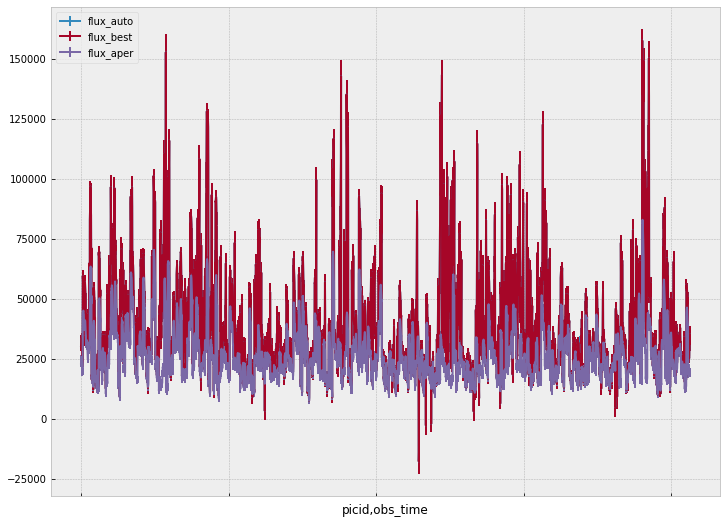

In [27]:
plt.figure(figsize=(12, 9))
binned_flux.flux_auto.plot(yerr=binned_flux.fluxerr_auto)
binned_flux.flux_best.plot(yerr=binned_flux.fluxerr_best)
binned_flux.flux_aper.plot(yerr=binned_flux.fluxerr_aper)
plt.legend()

In [9]:
target_table = sources.loc[sources.picid == picid]
target_table.tail()

,picid,mag_auto,magerr_auto,x,y,xpeak_image,ypeak_image,ra,dec,background,...,flux_max,fwhm_image,flags,snr,tmag,vmag,catalog_sep_arcsec,exp_time,airmass,file
obs_time,,,,,,,,,,,,,,,,,,,,,
2018-08-22 07:34:51,256364928,13.8155,0.0663,2205,1377,2204.6545,1376.8474,300.181451,22.709244,3446.293,...,4840.726,2.74,0,16.380523,6.81314,7.67,3.023841,35.0,1.105535,20180822T073451.fits
2018-08-22 07:36:46,256364928,13.5735,0.0500,2205,1377,2204.5242,1377.4723,300.180821,22.709228,3207.228,...,5047.343,2.86,0,21.698702,6.81314,7.67,4.803945,34.9,1.108975,20180822T073646.fits
2018-08-22 07:40:32,256364928,13.8733,0.0682,2204,1376,2204.4910,1376.3289,300.181490,22.709188,3450.376,...,5717.007,2.32,0,15.924494,6.81314,7.67,3.073365,35.0,1.115969,20180822T074032.fits
2018-08-22 07:42:20,256364928,13.6155,0.0562,2205,1377,2204.7744,1377.0355,300.181249,22.708985,3278.097,...,6168.068,2.56,0,19.337396,6.81314,7.67,4.153752,35.0,1.119438,20180822T074220.fits
2018-08-22 07:44:07,256364928,13.5614,0.0489,2204,1378,2204.5061,1377.5029,300.180853,22.709140,3172.034,...,5657.140,2.81,0,22.223315,6.81314,7.67,4.859128,35.0,1.122911,20180822T074407.fits


#### Basic Aperture Photometry - sextractor

We can look at the basic aperture photometry as it comes out of `sextractor`. A 6 pixel aperture is used and the local background is subtracted. Instrumental magnitudes are calculated with a zeropoint offset of 25.

Here we show the raw instrumental magnitudes as well as the magnitude averaged across a 20 minute time bin.

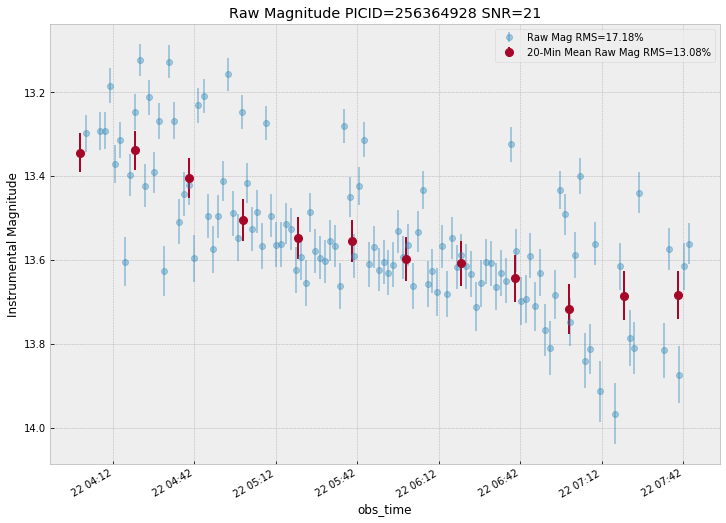

In [10]:
min_bin = 20
plt.figure(figsize=(12, 9))
target_table.mag_auto.plot(ls='', marker='o', yerr=target_table.magerr_auto, alpha=0.4, label=f'Raw Mag RMS={target_table.mag_auto.std():.02%}')

binned_flux.loc[picid].mag_auto.plot(
                            ls='', marker='o', ms=8, 
                            yerr=binned_flux.loc[picid].magerr_auto, 
                            label=f'{min_bin}-Min Mean Raw Mag RMS={binned_flux.loc[picid].mag_auto.std():.02%}')

plt.title(f'Raw Magnitude PICID={picid} SNR={target_table.snr.mean():.0f}')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

#### Differential photometry - sextractor

We can find some of the bright stars in the field and use them to correct for some of the major systematic effects that we are seeing in the light curve. We manually select three stars in the field and average them together and plot this versus our target instrumental magnitude.

Found 3 stars of similar magnitude


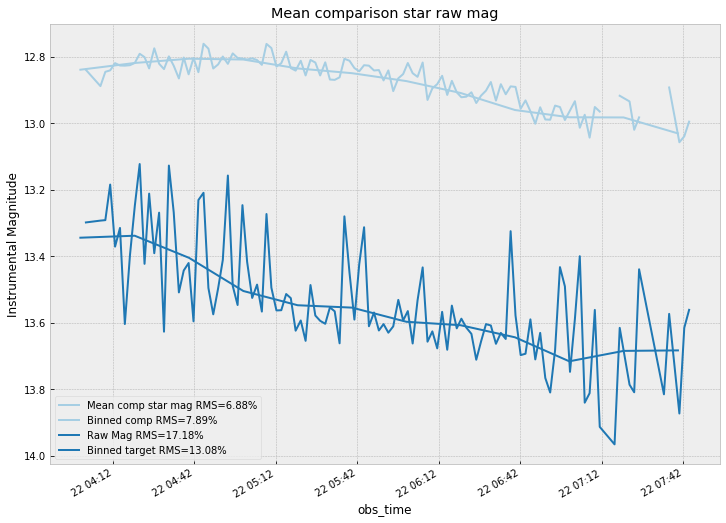

In [11]:
# Get the bright stars
bright_stars = sources.groupby('picid').snr.mean().sort_values(ascending=False).index.values[10:13]
# bright_stars = list(set(sources.loc[(sources.vmag == 7.67)].picid.values))
# bright_stars = list(set(sources.loc[np.logical_and(sources.vmag >= target_table.iloc[0].vmag - 0.1, sources.vmag <= target_table.iloc[0].vmag + 0.1)].picid))[0:5]
# bright_stars.remove(picid)
print(f'Found {len(bright_stars)} stars of similar magnitude')
bright_table = sources.loc[np.isin(sources.picid, bright_stars)]

# Plot the comp stars mean
plt.figure(figsize=(12, 9))
comp_star = bright_table.groupby('obs_time').mag_auto.mean()
# Sigma clip the comp star
comp_star = comp_star.mask(sigma_clip(comp_star).mask)
binned_comp_star = binned_flux.loc[bright_stars].groupby('obs_time').mean()

comp_star.plot(label=f'Mean comp star mag RMS={comp_star.std():.02%}', **styles['comp_star'])
binned_comp_star.mag_auto.plot(label=f'Binned comp RMS={binned_comp_star.mag_auto.std():.02%}', **styles['comp_star'])

# Plot target
target_table.mag_auto.plot(label=f'Raw Mag RMS={target_table.mag_auto.std():.02%}', **styles[picid])
binned_flux.loc[picid].mag_auto.plot(label=f'Binned target RMS={binned_flux.loc[picid].mag_auto.std():.02%}', **styles[picid])

plt.gca().invert_yaxis()
plt.ylabel('Instrumental Magnitude')
plt.title('Mean comparison star raw mag')
plt.legend()

Now we can take the mean-combined comparison star and use it to normalize our target light curve. We do the same for the comparison stars, which we would expect to be flat.

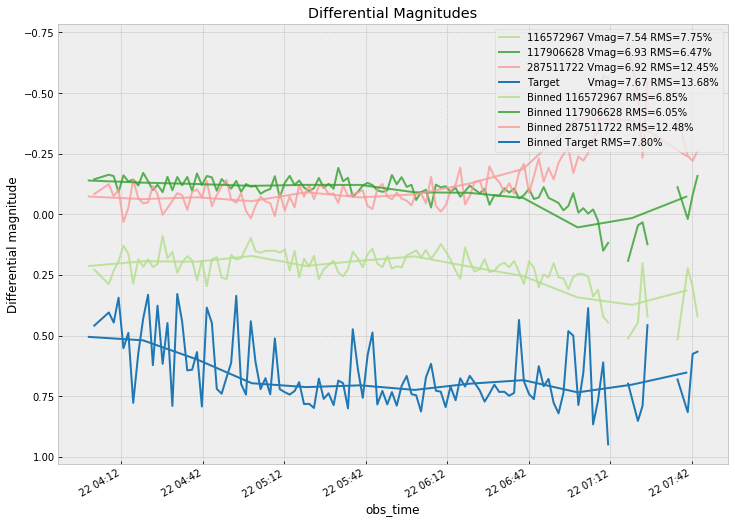

In [12]:
plt.figure(figsize=(12, 9))
for i, info in enumerate(bright_table.groupby('picid')):
    pid = info[0]
    row = info[1]
    c0 = (row.mag_auto - comp_star)
    c0.plot(label=f'{pid} Vmag={row.iloc[0].vmag:.02f} RMS={c0.std():.02%}', alpha=0.8, **styles[pid])

# Target
t0 = (target_table.mag_auto - comp_star)
t0.plot(label=f'Target         Vmag={target_table.iloc[0].vmag:.02f} RMS={t0.std():.02%}', **styles[picid])    
    
# Binned comparisons
for pid, row in binned_flux.loc[bright_stars].groupby('picid'):
    c1 = (row.loc[pid].mag_auto - binned_comp_star.mag_auto)
    c1.plot(label=f'Binned {pid} RMS={c1.std():.02%}', alpha=0.8, **styles[pid])
    
# Binned target
t1 = (binned_flux.loc[picid].mag_auto - binned_comp_star.mag_auto)
t1.plot(label=f'Binned Target RMS={t1.std():.02%}', **styles[picid])

plt.gca().invert_yaxis()

plt.ylabel('Differential magnitude')
plt.title('Differential Magnitudes')
plt.legend(loc=1)

We see that the comparison stars are corrected fairly well but our target still has some variability. In addition to the large dip (which we would hope to be a transit) the light curve has a lot more noise that almost appears periodic. This is the periodic motion of the star (due to the mechanics of the mount) on the RGB pixel pattern. At some points, for example, the centroid of the star's light might be more directly concentrated on a green pixel, at other times a red. Because these colors have different sensitivity responses we see either more or less signal. The data that is binned on time effectively smooths over these differences.

The brighter comparison stars still exhibit some of this pattern but it is less noticable because they are brighter and the light is already spread across more pixels to being with.

## Postage Stamp Cube (PSC)

We can use the positions from the `sources` table to extract a postage stamp for the target for each frame in the observation.

Unlike traditional photometry, which would try to place the centroid of the source directly in the center of the stamp, it is important for our purposes that each frame of the stamp have the same underlying pixel pattern. As a standard we enforce that all stamps have a red pixel in the bottom-left of the stamp provided that the origin (`(0,0)`) is in the bottom-left of the overall frame.

The star's centroid is placed within the center superpixel and a stamp size must have have an odd number of superpixels on each side of the center superpixel. The minimum stamp size is therefore 3x3 superpixels, or 6x6 regular pixels. The next size would be 5x5 superpixels or 10x10 pixels. Generally a stamp shold not need to be larger than 14x14 pixels. The size of the postage stamp will have an effect on the comparison stars that are selected by our algorithm.

A smaller 4-pixel aperture can later be pulled from the original stamp for any final photometric steps.

In [13]:
stamp_size = (6, 6)

In [ ]:
# Get the stamp slices for the observation
stamps = list()
for obstime, row in target_table.iterrows():
    s0 = helpers.get_stamp_slice(row.x, row.y, stamp_size=stamp_size)
    with fits.open(os.path.join(base_dir, row.file)) as hdul:
        d0 = hdul[0].data.astype(np.int) - int(row.background)
        stamps.append(d0[s0])
    
stamps = np.array(stamps)

In [ ]:
plt.plot(target_table.index, stamps.reshape(stamps.shape[0], -1).sum(1))
target_table.flux_auto.plot(ls='', marker='o', yerr=target_table.fluxerr_auto, alpha=0.4, label=f'Raw Mag RMS={target_table.mag_auto.std():.02%}')
plt.legend()

#### Color channel photometry

In [306]:
stamp_size = 4

color_sums = list()
for date_obs, row in tqdm(target_table.iterrows(), total=len(target_table)):
    
    # Get the data for the entire frame
    data = fits.getdata(os.path.join(base_dir, row.file)) 
    
    # Get the stamp for the target
    target_slice = helpers.get_stamp_slice(row.x, row.y, stamp_size=(stamp_size, stamp_size), ignore_superpixel=True)
    
    # Remove the background (from sextractor)
    stamp = data[target_slice] - row.background

    row_sums = [stamp.sum()]
    row_sums.extend(helpers.get_rgb_data(stamp).reshape(3, -1).sum(1))
    color_sums.append(row_sums)

color_sums = pd.DataFrame(color_sums, columns=['all', 'r', 'g', 'b'], index=target_table.index)

In [302]:
norm_colors = (color_sums / color_sums.mean())

In [303]:
norm_combined = (target_table.flux_auto / target_table.flux_auto.mean())

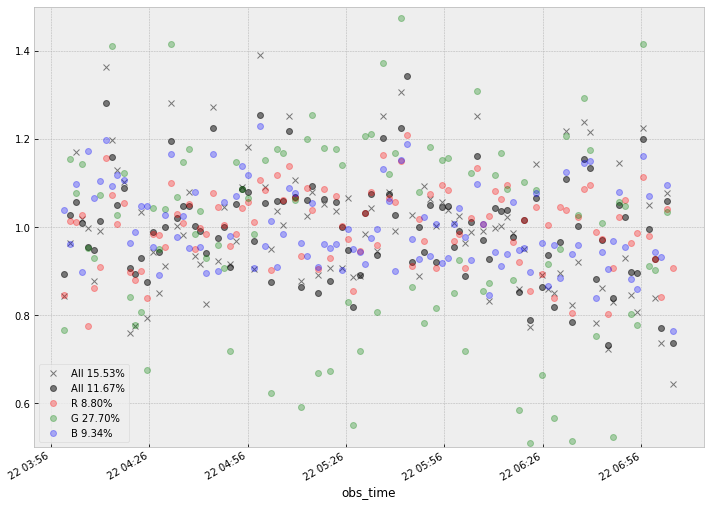

In [304]:
plt.figure(figsize=(12, 9))

norm_combined.plot(ls='', marker='x', color='k', alpha=0.5, label=f'All {norm_combined.std():.02%}')

norm_colors['all'].plot(ls='', marker='o', color='k', alpha=0.5, label='All {:.02%}'.format(norm_colors['all'].std()))
norm_colors.r.plot(ls='', marker='o', color='r', alpha=0.3, label=f'R {norm_colors.r.std():.02%}')
norm_colors.g.plot(ls='', marker='o', color='g', alpha=0.3, label=f'G {norm_colors.g.std():.02%}')
norm_colors.b.plot(ls='', marker='o', color='b', alpha=0.3, label=f'B {norm_colors.b.std():.02%}')

plt.ylim(0.5, 1.5)
plt.legend()

See [Find Similar Stars](PIAA-Find-Similar-Stars.ipynb)